In [18]:
!nvidia-smi


Mon Apr 28 13:53:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0             32W /   70W |    1199MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
# Install tooling 
!pip install -r requirements.txt
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuspatial-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [20]:
from numba import cuda
print(cuda.is_available())  # Should return True

True


In [21]:
!mkdir /home/cdsw/data

mkdir: cannot create directory ‘/home/cdsw/data’: File exists


In [22]:
import boto3
import os
import pandas as pd
from io import BytesIO

# For runtimes with python kernels 3.6 and 3.7 please install raz_client==1.0.2
import cml.data_v1 as cmldata

CONNECTION_NAME = "S3 Object Store"

conn = cmldata.get_connection(CONNECTION_NAME)

# Sample usage
bucket_name = "goes-se-sandbox"
prefix = "data/geospatial/nw/"

client = conn.get_base_connection()

# For a list of per-bucket operations supported, refer to
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html

import boto3

# Create a session
session = boto3.Session(
    aws_access_key_id="change-me",
    aws_secret_access_key="change-me",
    region_name="eu-central-1"
)

# S3 resource (for object operations like download/upload)
s3_resource = session.resource("s3")

# S3 client (for low-level operations like list_objects_v2)
s3_client = session.client("s3")


# Using the client to list objects
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

#if "Contents" in response:
#    for obj in response["Contents"]:
#        print(obj["Key"])
#else:
#    print


# Get the first LSZ file in the prefix
file_key = next(obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.laz'))
file_name = os.path.basename(file_key)

# Now use s3_client (not s3_resource) to get the object
file_obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# If you want to read the binary content:
binary_data = file_obj['Body'].read()

# Just for confirmation
print(f"Downloaded file: {file_key}, size: {len(binary_data)} bytes")

# Define local path to save the file
local_path = '/home/cdsw/data/'+os.path.basename(file_key)  # just the filename

# Write to local file
with open(local_path, 'wb') as f:
    f.write(binary_data)

# classic hdfs for transfer
#!hdfs dfs -ls s3a://goes-se-sandbox/data/geospatial/nw

print(f"File saved locally as: {local_path}")

Downloaded file: data/geospatial/nw/3dm_32_280_5652_1_nw.laz, size: 103876432 bytes
File saved locally as: /home/cdsw/data/3dm_32_280_5652_1_nw.laz


In [23]:
%load_ext cuml.accel

import cudf
import laspy
import lazrs
import numpy as np

def process_las_to_cudf(file_path):
    with laspy.open(file_path) as las:
        las = las.read()
        return cudf.DataFrame({
            'x': cudf.Series(las.x, dtype='float64'),
            'y': cudf.Series(las.y, dtype='float64'),
            'z': cudf.Series(las.z, dtype='float64'),
            'intensity': cudf.Series(np.asarray(las.intensity), dtype='int32'),
            'return_num': cudf.Series(np.asarray(las.return_number), dtype='int32'),
            'classification': cudf.Series(np.asarray(las.classification), dtype='int32')
        })

# Process file

gdf = process_las_to_cudf(local_path)



The cuml.accel extension is already loaded. To reload it, use:
  %reload_ext cuml.accel


In [24]:
# Show results
print(gdf.head())
print(f"Number of points: {len(gdf)}")

           x           y      z  intensity  return_num  classification
0  280000.00  5652013.19  59.88      41571           1               2
1  280000.00  5652013.48  59.93      45066           1               2
2  280000.32  5652013.23  59.89      40981           1               2
3  280000.59  5652013.26  59.88      40959           1               2
4  280000.32  5652013.52  60.06      45284           1              20
Number of points: 15787378


In [25]:
# 1. Get row count (equivalent to Spark's count())
print(f"Processed {len(gdf)} points")  # or gdf.shape[0]

# 2. Show first rows (equivalent to Spark's show())
print(gdf.head(5))  # Shows first 5 rows with formatting

# 3. Quick summary
print(gdf.describe())  # Shows statistics for numeric columns

Processed 15787378 points
           x           y      z  intensity  return_num  classification
0  280000.00  5652013.19  59.88      41571           1               2
1  280000.00  5652013.48  59.93      45066           1               2
2  280000.32  5652013.23  59.89      40981           1               2
3  280000.59  5652013.26  59.88      40959           1               2
4  280000.32  5652013.52  60.06      45284           1              20
                  x             y             z     intensity    return_num  \
count  1.578738e+07  1.578738e+07  1.578738e+07  1.578738e+07  1.578738e+07   
mean   2.805696e+05  5.652512e+06  7.544791e+01  3.348586e+04  1.692712e+00   
std    3.062926e+02  2.797843e+02  1.573714e+01  1.118075e+04  1.103285e+00   
min    2.800000e+05  5.652000e+06  4.947000e+01  0.000000e+00  0.000000e+00   
25%    2.802987e+05  5.652274e+06  6.241000e+01  2.405100e+04  1.000000e+00   
50%    2.806059e+05  5.652510e+06  7.148000e+01  3.606600e+04  1.000000e+0

In [26]:
import cudf

# Assuming your data has a 'classification' column
# Standard LAS classification codes: 2 = building
buildings = gdf[gdf['classification'] == 2].copy()

print(f"Found {len(buildings)} building points")
print(buildings.head())

Found 7015523 building points
            x           y      z  intensity  return_num  classification
0   280000.00  5652013.19  59.88      41571           1               2
1   280000.00  5652013.48  59.93      45066           1               2
2   280000.32  5652013.23  59.89      40981           1               2
3   280000.59  5652013.26  59.88      40959           1               2
12  280001.60  5652013.38  59.91      43471           1               2


In [27]:
# Group by classification and count rows
count_by_class = gdf.groupby('classification').size()
count_by_z = gdf.groupby('z').size()

# Print results
print("Point counts by classification:")
print(count_by_class,count_by_z)

Point counts by classification:
classification
20    2625804
2     7015523
18       1234
24       1299
26     134367
1     6009151
dtype: int64 z
80.18     2328
92.62     2872
100.86    1193
90.21     2426
95.20     1343
          ... 
72.81     3458
56.96     3769
124.56     126
116.26     284
78.16     2174
Length: 8125, dtype: int64


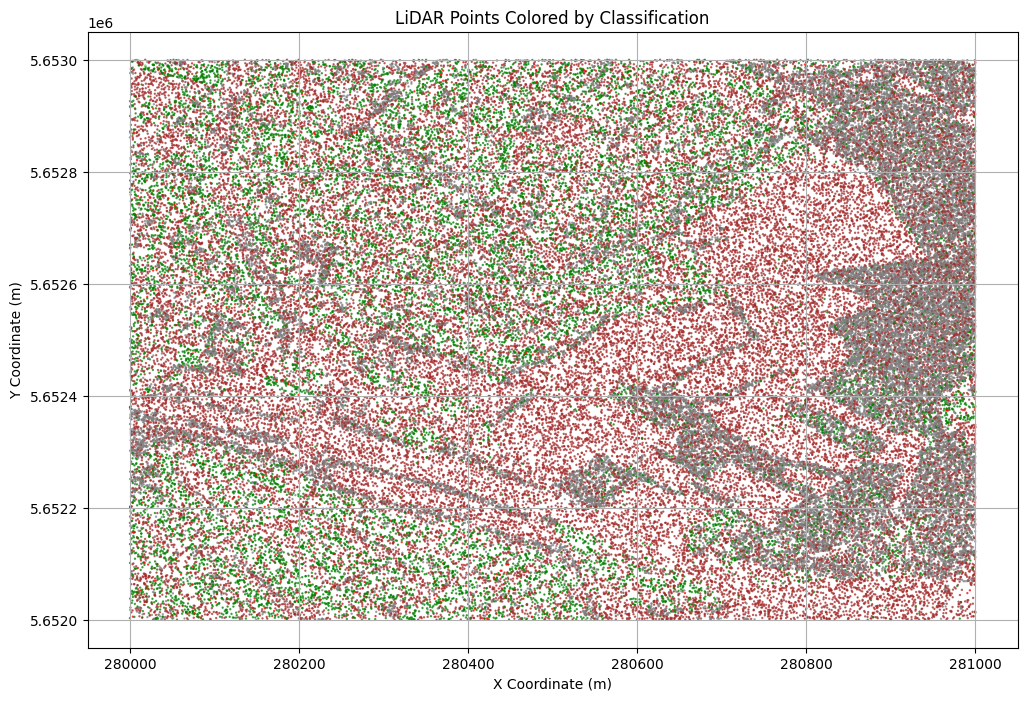

In [28]:
import matplotlib.pyplot as plt

# Sample data
sample_df = gdf.sample(n=100000).to_pandas() if len(gdf) > 10000 else gdf.to_pandas()

# Extended color map with default color for unknown classes
color_map = {
    0: 'black',    # Never classified
    1: 'gray',     # Unclassified
    2: 'brown',    # Ground
    18: 'lightgreen', # Low vegetation
    20: 'green',    # Medium vegetation
    24: 'darkgreen', # High vegetation
    26: 'red',      # Buildings
    7: 'pink',     # Noise
    8: 'yellow',   # Model keypoint
    9: 'blue',     # Water
    # Add any other codes present in your data
}

# Fill missing classifications with a default color
sample_df['color'] = sample_df['classification'].map(color_map).fillna('purple')

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(
    sample_df['x'],
    sample_df['y'],
    c=sample_df['color'],
    s=0.5,
    alpha=0.7
)
plt.title("LiDAR Points Colored by Classification")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.grid(True)
plt.show()

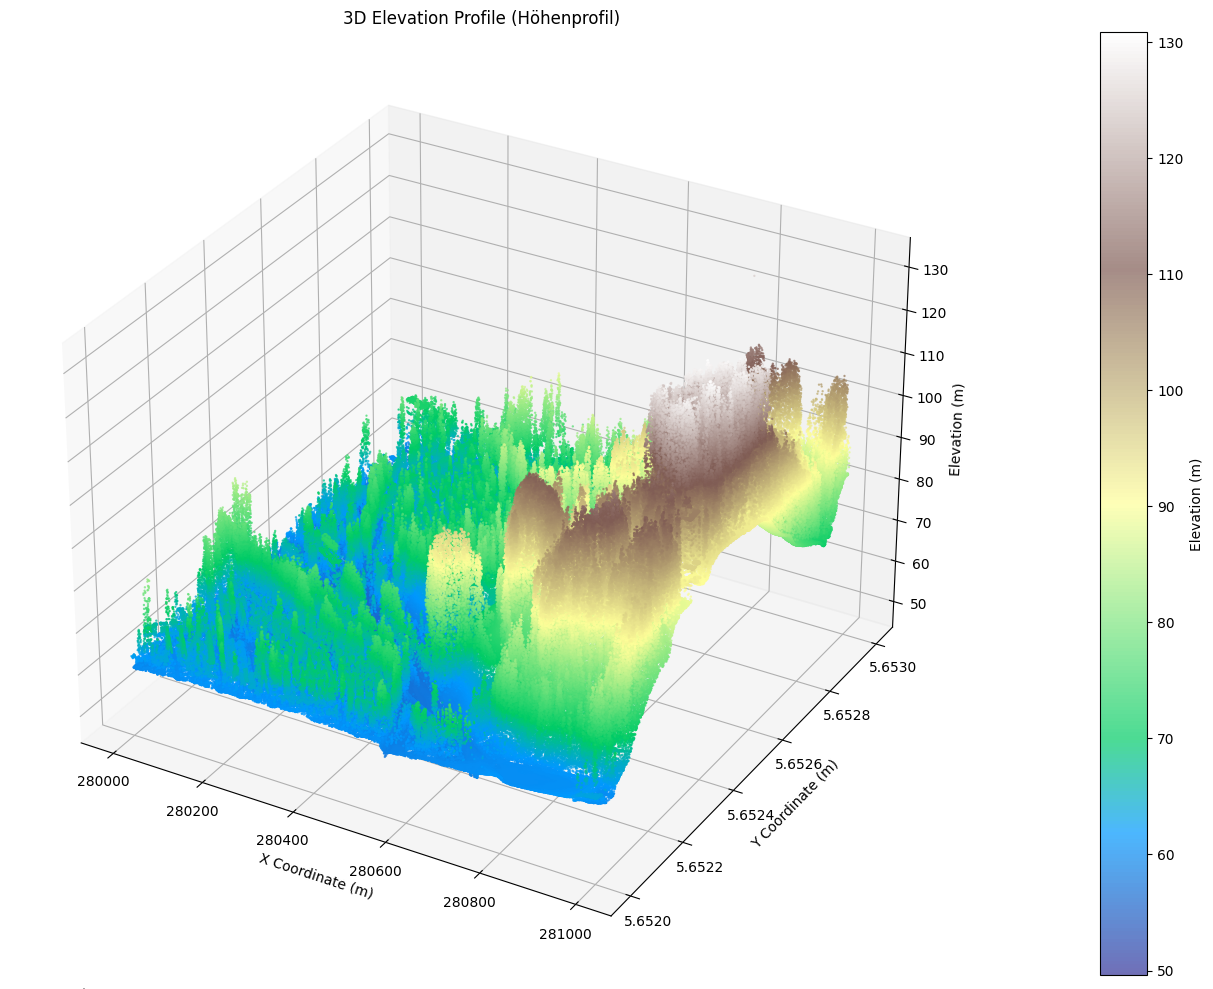

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Sample data (convert to pandas for visualization)
sample_df = gdf.sample(n=1000000).to_pandas() if len(gdf) > 50000 else gdf.to_pandas()

# Create figure
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Color by elevation
sc = ax.scatter(
    sample_df['x'],
    sample_df['y'],
    sample_df['z'],
    c=sample_df['z'],
    cmap='terrain',
    s=0.5,
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Elevation (m)')

# Labels and title
ax.set_title('3D Elevation Profile (Höhenprofil)')
ax.set_xlabel('X Coordinate (m)')
ax.set_ylabel('Y Coordinate (m)')
ax.set_zlabel('Elevation (m)')

plt.tight_layout()
plt.show()

In [30]:
print ( gdf )


                  x           y      z  intensity  return_num  classification
0         280000.00  5652013.19  59.88      41571           1               2
1         280000.00  5652013.48  59.93      45066           1               2
2         280000.32  5652013.23  59.89      40981           1               2
3         280000.59  5652013.26  59.88      40959           1               2
4         280000.32  5652013.52  60.06      45284           1              20
...             ...         ...    ...        ...         ...             ...
15787373  280999.55  5652999.19  90.36      21451           1               1
15787374  280999.88  5652999.40  88.71      32789           1               1
15787375  280999.89  5652999.27  90.05      23483           1               1
15787376  280999.88  5652999.85  89.21      20403           2               1
15787377  280999.89  5652999.48  90.38      21932           1               1

[15787378 rows x 6 columns]


In [48]:
from cuml.cluster import KMeans
import numpy as np

# Sample and keep index to map labels correctly
coords = gdf[['x', 'y']].sample(n=100000, random_state=0)
coords = coords.astype(np.float32)

# Fit and predict
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(coords)

# Now, create a new column ONLY for sampled points
gdf.loc[coords.index, 'kmeans_cluster'] = labels

# Sample data (convert to pandas for visualization)
sample_df = gdf.sample(n=1000000).to_pandas() if len(gdf) > 50000 else gdf.to_pandas()


x                 15787378
y                 15787378
z                 15787378
intensity         15787378
return_num        15787378
classification    15787378
kmeans_cluster    15787378
dtype: int64

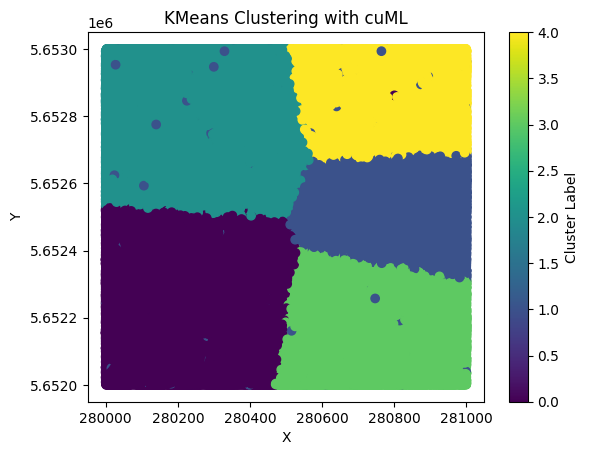

In [50]:
import matplotlib.pyplot as plt

# Convert to numpy (CPU) before plotting
x = sample_df['x'].to_numpy()
y = sample_df['y'].to_numpy()
clusters = sample_df['kmeans_cluster'].to_numpy()

plt.scatter(x, y, c=clusters, cmap='viridis')
plt.title('KMeans Clustering with cuML')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
!mkdir /home/cdsw/results

In [ ]:
import cudf
from cuml.cluster import DBSCAN
import geopandas as gpd

# Check if gdf is a cudf DataFrame
if not isinstance(gdf, cudf.DataFrame):
    gdf = cudf.from_pandas(gdf)  # Convert pandas DataFrame to cudf

coords = gdf[["x", "y"]].dropna().astype("float32")
# Try adjusting DBSCAN parameters
db = DBSCAN(eps=10, min_samples=10)  # Increase eps if necessary
labels = db.fit_predict(coords)

gdf["cluster"] = labels

# Proceed with generating polygons as you did before
streets = []
cluster_ids = gdf["cluster"].unique().to_pandas().tolist()

for cid in cluster_ids:
    if cid == -1:
        continue  # Skip noise
    cluster = gdf[gdf["cluster"] == cid][["x", "y"]].to_pandas()
    if len(cluster) < 3:
        continue
    points = MultiPoint(cluster[["x", "y"]].values)
    poly = points.convex_hull  # Or alpha shape if you want tighter fitting
    streets.append({"geometry": poly, "cluster": cid})

# 4. Create GeoDataFrame and export
gdf_streets = gpd.GeoDataFrame(streets, crs="EPSG:25832")
gdf_streets.to_file("results/street_polygons.geojson", driver="GeoJSON")



In [ ]:
print ( gdf_streets)


In [ ]:
# find Buildingts 
import laspy
import cudf
from cuml.cluster import DBSCAN
from shapely.geometry import MultiPoint
import geopandas as gpd

# 3. Cluster with DBSCAN
db = DBSCAN(eps=3.0, min_samples=20)  # tune eps as needed
labels = db.fit_predict(gdf[["x", "y"]])
gdf["cluster"] = labels

# 4. Create polygons
polygons = []
for cid in gdf["cluster"].unique().to_pandas():
    if cid == -1:
        continue
    cluster = gdf[gdf["cluster"] == cid].to_pandas()
    if len(cluster) < 3:
        continue
    points = MultiPoint(cluster[["x", "y"]].values)
    poly = points.convex_hull
    polygons.append({"geometry": poly, "cluster": cid})

# 5. Save as GeoJSON
gdf_buildings = gpd.GeoDataFrame(polygons, crs="EPSG:25832")
gdf_buildings.to_file("results/building_footprints.geojson", driver="GeoJSON")


In [ ]:
print (gdf_buildings)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import geopandas as gpd

# Create the figure and axes
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Function to plot polygons in 3D (extruding based on Z height)
def plot_polygon_3d(polygon, ax, height=1, color='orange', alpha=0.6):
    if polygon.is_empty:
        return
    if polygon.geom_type == 'Polygon':
        x, y = polygon.exterior.xy
        z = np.zeros_like(x)  # Base Z values (flat)
        ax.plot_trisurf(x, y, z, color=color, alpha=alpha)

        # Extrude for 3D (height)
        for i in range(len(x)):
            ax.plot([x[i], x[i]], [y[i], y[i]], [0, height], color=color, alpha=alpha)
    elif polygon.geom_type == 'MultiPolygon':
        for poly in polygon:
            plot_polygon_3d(poly, ax, height, color, alpha)

# Plot Buildings as Extruded Polygons (with some height)
for _, building in gdf_buildings.iterrows():
    plot_polygon_3d(building['geometry'], ax, height=building['geometry'].area * 0.05, color='orange', alpha=0.6)

# Plot Streets (Flat)
for _, street in gdf_streets.iterrows():
    plot_polygon_3d(street['geometry'], ax, height=0, color='gray', alpha=0.3)

# Labels and Styling
ax.set_title("3D Streets and Buildings", fontsize=16)
ax.set_xlabel("X (Easting)")
ax.set_ylabel("Y (Northing)")
ax.set_zlabel("Z (Elevation)")
ax.view_init(elev=30, azim=45)  # Adjust view angle for better 3D perception

plt.tight_layout()
plt.show()
